# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
# %pip install belashovplot
# %pip install optuna
# %pip install timm

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm
import pickle

C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (16, 16)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Оптимизиция при оптимальной дистанции распространения

## Установка не изменяемых параметров

In [7]:
# Предпочтительные параметры
size = 50.0E-6
near_N = 300
near_length = 5.0E-3
wavelength = 500.0E-9
optuna_epochs = 1

# Параметры когерентности
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 7

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size

cppp = upper_integer(near_N * size / length)
N = int(length / size) * cppp

reference_distance = length * sqrt((size/wavelength)**2 - 1)

## Инициализация некогерентной обёртки

In [8]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)

In [9]:
autocorr = autocorrelation(incoherent.sample(), dims=[1,2], mean_dim=0, split=mean_samples)

In [10]:
autocorr_radius, _ = correlation_circle(autocorr, limits=((-length/2,+length/2),(-length/2,+length/2)), percent=0.8)
incoherent_distribution, incoherent_distribution_values = distribution(incoherent.sample(), N=100, return_values=True)
incoherent_sample = incoherent.sample()[0].cpu()
print('Радиус автокорреляции:', engineering(autocorr_radius, 'м'))

Радиус автокорреляции: 16.722 мкм


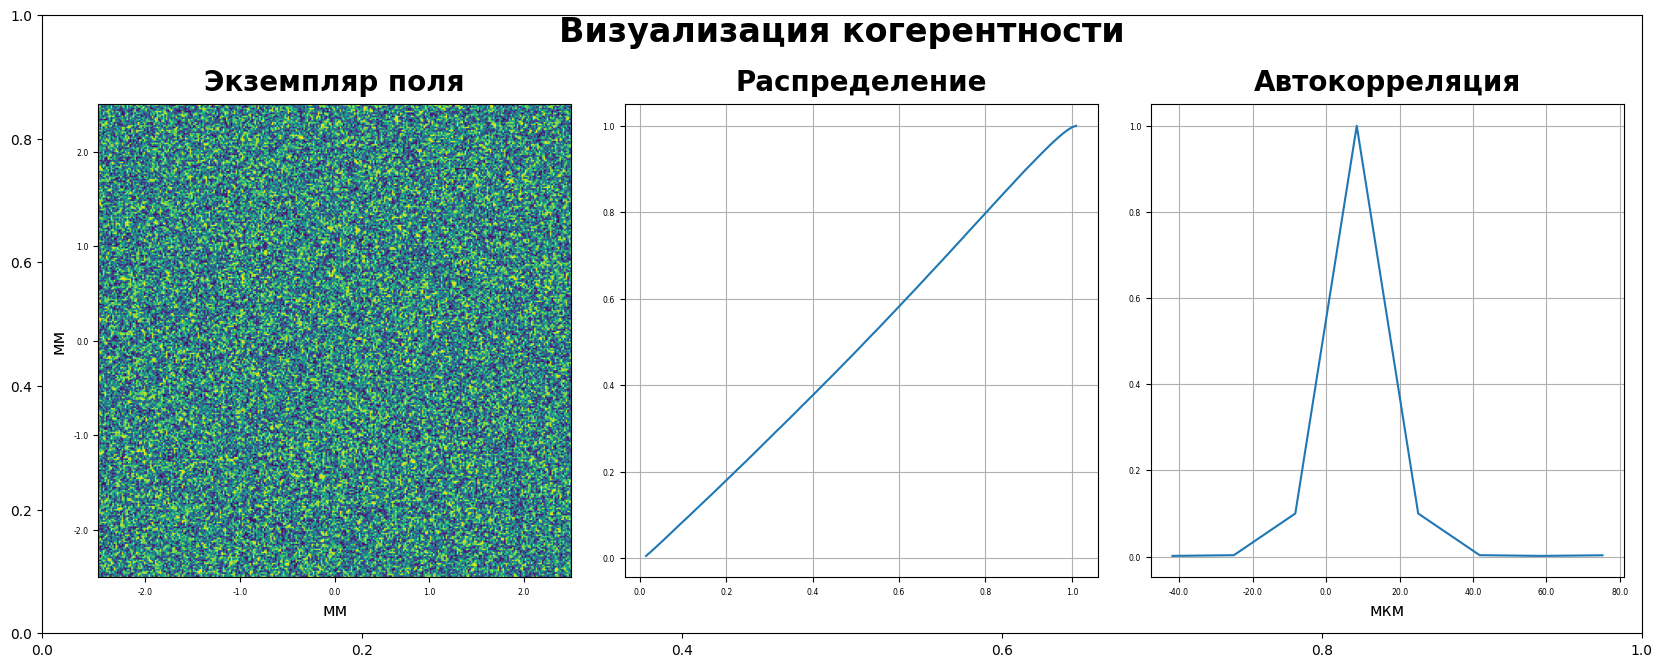

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Визуализация когерентности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_rad, unit_rad = engineering.separatedformatter(autocorr_radius, 'м')

axes = plot.axes.add(0,0)
axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Экземпляр поля')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(incoherent_distribution_values, incoherent_distribution.cpu())
plot.graph.title('Распределение')

p0 = int(autocorr.shape[1]*(1 - 4*autocorr_radius/length)/2)
p1 = p0 + int(8*autocorr.shape[1]*autocorr_radius/length)
axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(numpy.linspace(-length/2, +length/2, autocorr.shape[1])[p0:p1], autocorr[autocorr.shape[0]//2][p0:p1]/autocorr.max())
axes.xaxis.set_major_formatter(formatter_rad)
plot.graph.label.x(unit_rad)
plot.graph.title('Автокорреляция')

plot.show()

## Инициализация детекторов

In [12]:
detectors_amount = 24
detector_size = length / 60

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)

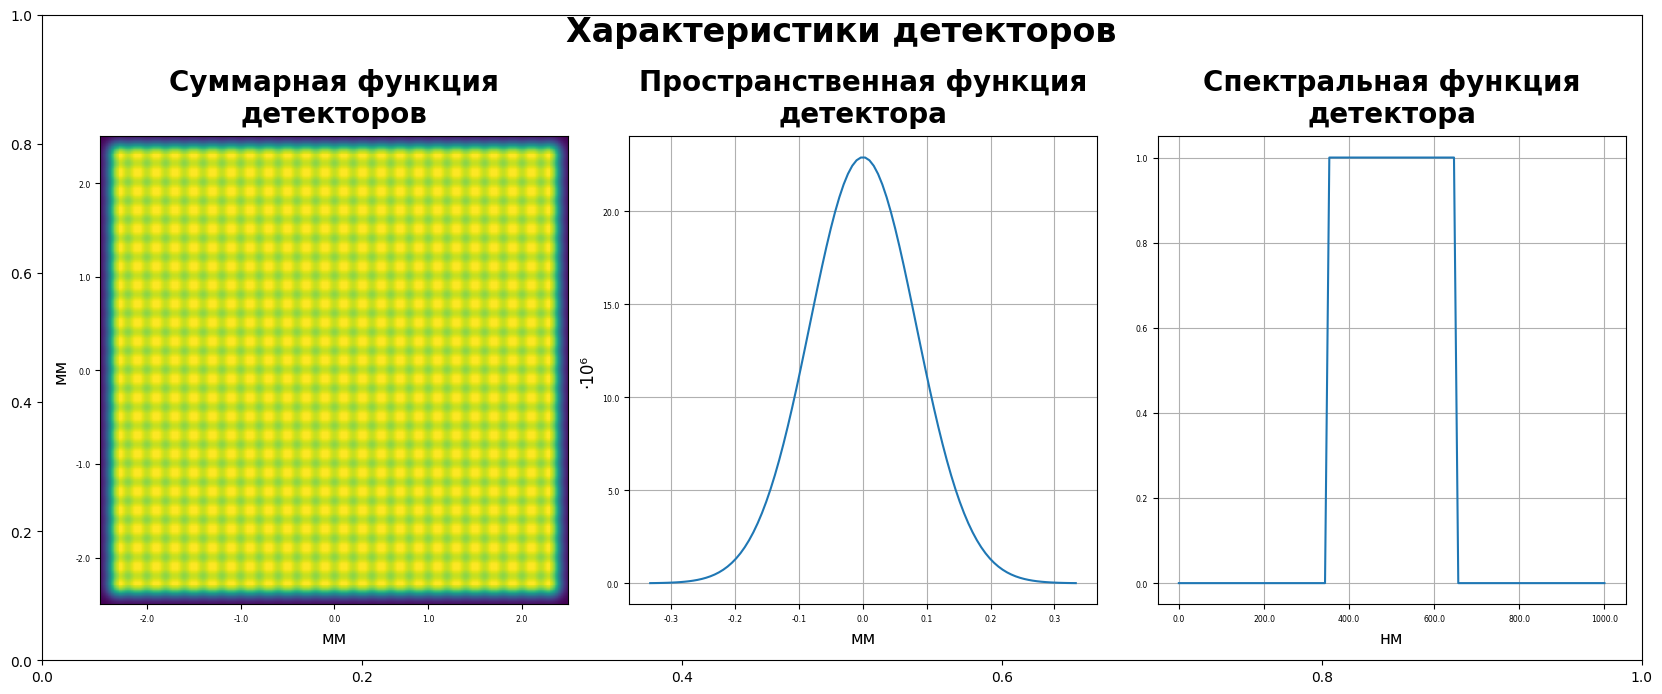

In [13]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.horizontal(0.1)
plot.title('Характеристики детекторов')

x_linspace = torch.linspace(-4*detector_size,+4*detector_size,100)
y_linspace = detectors_filter(x_linspace, x_linspace)[50]
wl_linspace = torch.linspace(0, 1000.0E-9, 100)
s_linspace = spectral_filter(wl_linspace)
formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_d, unit_d = scientific.separatedformatter(y_linspace.max(), '')
formatter_wl, unit_wl = engineering.separatedformatter(wl_linspace.max(), 'м')

axes = plot.axes.add(0,0)
axes.imshow(detectors.filter, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Суммарная функция детекторов')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(x_linspace, y_linspace)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_d)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_d)
plot.graph.title('Пространственная функция детектора')

axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(wl_linspace, s_linspace)
axes.xaxis.set_major_formatter(formatter_wl)
plot.graph.label.x(unit_wl)
plot.graph.title('Спектральная функция детектора')

plot.show()

## Инициализация электронной части

In [14]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10).to(device)

## Комбинированная функция 

In [15]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

## Выбор диапазона раcстояния распространения

In [16]:
# Настройка диапазона
distance_left_multiplier = 0.05
distance_right_multiplier = 0.5

slices = 100
distance_samples = 4
distance_array = numpy.linspace(reference_distance*distance_left_multiplier, reference_distance*distance_right_multiplier, distance_samples)

In [17]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(length*2))
p1 = p0 + int(N*size/length)
initial[0,0,p0:p1,p0:p1] = 1.0

chunker = CudaMemoryChunker().to(device) 
with torch.no_grad():
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance).to(device)
            chunker.attach_forward(propagation.forward)
            incoherent.attach_forward(chunker.forward)
            result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.95s/it]


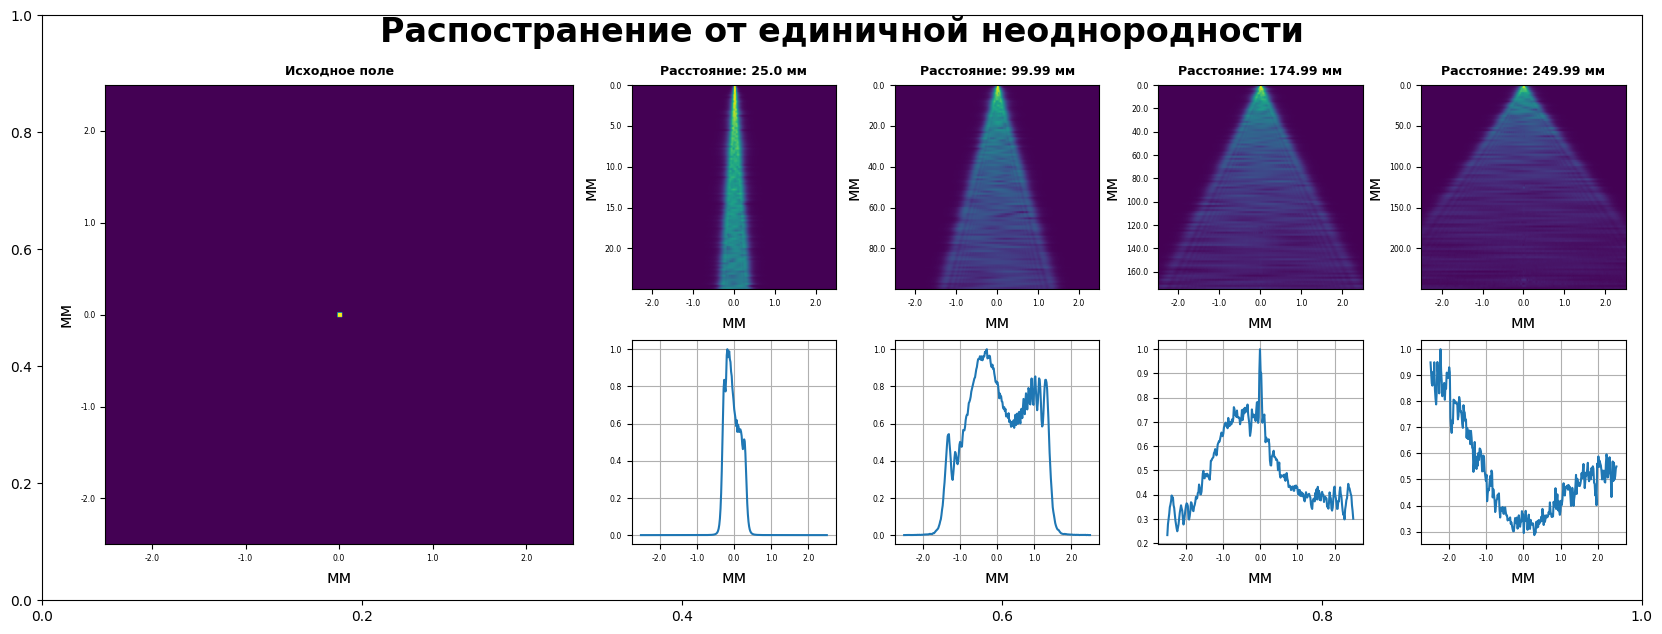

In [18]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (distance, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(distance, 'м')
    plot.description.column.top(f"Расстояние: {engineering(distance,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.0001), aspect='auto', extent=[-length/2,+length/2,distance,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

## Вариации изменяемых параметров

In [19]:
# Установить вручную по картинкам выше (чем больше покрытие и меньше шумов, тем лучше)
distance_limits = (80.0E-3, 180.0E-3)

In [20]:
masks_amount_limits = (3, 10)
batch_size_limits = (20, 40)
learning_rate_limits = (0.00001, 0.1)
loss_functions_proportion_limits = (0.0, 1.0)
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

## Вывод окончательных параметров

In [21]:
print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(size, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       300
Количество пикселей маски:                100
Размер оптических элементов:              5.0 мм
Размер пикселя маски:                     50.0 мкм
Расстояние между слоями:                  249.987 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           50.0 мкм
Количество усреднений:                    7


## Функция цели для optuna и оптимизация

In [22]:
def objective(trial:optuna.trial):
    masks_amount = trial.suggest_int('masks amount', *masks_amount_limits)
    batch_size = trial.suggest_int('batch size', *batch_size_limits)
    distance = trial.suggest_float('distance', *distance_limits)
    learning_rate = trial.suggest_float('learning rate', *learning_rate_limits, log=True)
    loss_functions_proportion = trial.suggest_float('cross entorpy proportion', *loss_functions_proportion_limits)
    optimizer_type = trial.suggest_categorical('optimizer type', optimizer_types_list.keys())

    print('Эксперимент:')
    print(f"\tКоличетсво масок:  {masks_amount}")
    print(f"\tРазмер батча:      {batch_size}")
    print(f"\tДистанция:         {engineering(distance, 'м')}")
    print(f"\tСкорость обучения: {learning_rate}")
    print(f"\tПропорция CELoss:  {loss_functions_proportion}")
    print(f"\tТип оптимизатора:  {optimizer_type}")
    
    # Инициализация оптической части и гибридной модели
    propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
    phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
    amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
    elements = [phase_modulators[0], amplitude_modulators[0]]
    for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
        elements.append(propagation)
        elements.append(phase_modulator)
        elements.append(amplitude_modulator)
    elements.append(propagation)
    chunker = CudaMemoryChunker(sub_chunks=mean_samples)
    optical = CompositeModel(*elements)
    optical.wrap(chunker)
    optical.wrap(incoherent)
    optical.to(device)
    model = HybridModel(optical, detectors, electronic)
    
    # Подготовка данных, функции ошибки и оптимизатора
    dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64)
    dataset.train
    dataset.test
    loss_function = combined_loss(loss_functions_proportion)
    optimizer = optimizer_types_list[optimizer_type](model.parameters(), lr=learning_rate)

    # Обучение модели
    for i in range(optuna_epochs):
        train(model, dataset, optimizer, loss_function)
    confusion_matrix = confusion(model, dataset)
    return 100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix)
study = optuna.create_study(study_name="ID2NN", storage="sqlite:///ID2NN.db", direction='maximize', load_if_exists=True)

[I 2024-05-04 05:30:25,072] Using an existing study with name 'ID2NN' instead of creating a new one.


In [23]:
study.optimize(objective, n_trials=100)

Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         84.893 мм
	Скорость обучения: 0.016891508320024423
	Пропорция CELoss:  0.9051360403707087
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0445941375446703, RPI1000: -0.27940525412741657: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:52<00:00,  2.13it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:01<00:00,  4.50it/s]
[I 2024-05-04 05:42:20,827] Trial 182 finished with value: 14.22 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08489313492698286, 'learning rate': 0.016891508320024423, 'cross entorpy proportion': 0.9051360403707087, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         81.522 мм
	Скорость обучения: 0.014285237551093588
	Пропорция CELoss:  0.9268500449393322
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.074593569027465, RPI1000: -0.013164900563204223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [12:03<00:00,  1.98it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:18<00:00,  3.64it/s]
[I 2024-05-04 05:55:44,927] Trial 183 finished with value: 14.56 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08152225474898331, 'learning rate': 0.014285237551093588, 'cross entorpy proportion': 0.9268500449393322, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         80.003 мм
	Скорость обучения: 0.008758494688796525
	Пропорция CELoss:  0.9722230377140931
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.1984526632111105, RPI1000: -0.012324237767260398: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [14:41<00:00,  1.58it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:28<00:00,  3.15it/s]
[I 2024-05-04 06:11:56,337] Trial 184 finished with value: 16.0 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.08000300590473962, 'learning rate': 0.008758494688796525, 'cross entorpy proportion': 0.9722230377140931, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      34
	Дистанция:         83.165 мм
	Скорость обучения: 0.006583123494985006
	Пропорция CELoss:  0.9434564854944393
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0679492635595347, RPI1000: -0.03073518906517438: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [11:18<00:00,  2.17it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:59<00:00,  4.93it/s]
[I 2024-05-04 06:24:16,074] Trial 185 finished with value: 16.65 and parameters: {'masks amount': 6, 'batch size': 34, 'distance': 0.08316536792729684, 'learning rate': 0.006583123494985006, 'cross entorpy proportion': 0.9434564854944393, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         87.536 мм
	Скорость обучения: 0.003287825034739246
	Пропорция CELoss:  0.9997350820198762
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.205788609789586, RPI1000: -0.06984318080313752: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:18<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:59<00:00,  4.80it/s]
[I 2024-05-04 06:35:36,228] Trial 186 finished with value: 18.97 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.0875355742119263, 'learning rate': 0.003287825034739246, 'cross entorpy proportion': 0.9997350820198762, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         142.982 мм
	Скорость обучения: 0.021269141329855634
	Пропорция CELoss:  0.8856403260990005
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.980384169770216, RPI1000: -0.02386364776424616: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:39<00:00,  1.99it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:07<00:00,  4.14it/s]
[I 2024-05-04 06:48:24,239] Trial 187 finished with value: 15.14 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.14298157457105617, 'learning rate': 0.021269141329855634, 'cross entorpy proportion': 0.8856403260990005, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         84.578 мм
	Скорость обучения: 0.011205166024427737
	Пропорция CELoss:  0.9806105597226279
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.10810858731607, RPI1000: -0.0839165587182698: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [08:53<00:00,  2.53it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.20it/s]
[I 2024-05-04 06:58:11,907] Trial 188 finished with value: 20.36 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.08457826725926955, 'learning rate': 0.011205166024427737, 'cross entorpy proportion': 0.9806105597226279, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      35
	Дистанция:         81.585 мм
	Скорость обучения: 0.0157410047722771
	Пропорция CELoss:  0.8285683248289558
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8101023065841768, RPI1000: -0.08306539424354223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [11:41<00:00,  2.04it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:07<00:00,  4.25it/s]
[I 2024-05-04 07:11:02,601] Trial 189 finished with value: 18.43 and parameters: {'masks amount': 7, 'batch size': 35, 'distance': 0.08158480889399557, 'learning rate': 0.0157410047722771, 'cross entorpy proportion': 0.8285683248289558, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         85.003 мм
	Скорость обучения: 0.009632326127983232
	Пропорция CELoss:  0.9287403046782028
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.917820493198565, RPI1000: -0.033348190013296204: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:17<00:00,  2.25it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:59<00:00,  4.67it/s]
[I 2024-05-04 07:22:21,246] Trial 190 finished with value: 21.51 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.085002788512132, 'learning rate': 0.009632326127983232, 'cross entorpy proportion': 0.9287403046782028, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  8
	Размер батча:      37
	Дистанция:         83.232 мм
	Скорость обучения: 0.012790620225216136
	Пропорция CELoss:  0.9578600764228735
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.096132198034078, RPI1000: -0.045690391343926835: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [12:58<00:00,  1.74it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:16<00:00,  3.55it/s]
[I 2024-05-04 07:36:37,648] Trial 191 finished with value: 21.1 and parameters: {'masks amount': 8, 'batch size': 37, 'distance': 0.08323165895820048, 'learning rate': 0.012790620225216136, 'cross entorpy proportion': 0.9578600764228735, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         80.065 мм
	Скорость обучения: 0.013957293065041787
	Пропорция CELoss:  0.9475390172329347
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0339734284614055, RPI1000: -0.07131626301036778: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [08:53<00:00,  2.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:52<00:00,  5.04it/s]
[I 2024-05-04 07:46:25,584] Trial 192 finished with value: 23.21 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.080064616735719, 'learning rate': 0.013957293065041787, 'cross entorpy proportion': 0.9475390172329347, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         80.014 мм
	Скорость обучения: 0.016566675135616774
	Пропорция CELoss:  0.9806100732397178
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0601672674549443, RPI1000: -0.07488497373182323: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [08:53<00:00,  2.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:52<00:00,  5.06it/s]
[I 2024-05-04 07:56:12,809] Trial 193 finished with value: 21.4 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.08001437567269472, 'learning rate': 0.016566675135616774, 'cross entorpy proportion': 0.9806100732397178, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      35
	Дистанция:         82.119 мм
	Скорость обучения: 0.004998461377044546
	Пропорция CELoss:  0.9167995409773438
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8763430608455876, RPI1000: -0.05170394215680572: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [08:56<00:00,  2.66it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:52<00:00,  5.48it/s]
[I 2024-05-04 08:06:03,105] Trial 194 finished with value: 24.06 and parameters: {'masks amount': 5, 'batch size': 35, 'distance': 0.08211882202268384, 'learning rate': 0.004998461377044546, 'cross entorpy proportion': 0.9167995409773438, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         86.289 мм
	Скорость обучения: 0.011293766070275674
	Пропорция CELoss:  0.9609324917637916
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9402556943523734, RPI1000: -0.07351178974084212: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.32it/s]
[I 2024-05-04 08:15:53,704] Trial 195 finished with value: 21.65 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.08628863098205265, 'learning rate': 0.011293766070275674, 'cross entorpy proportion': 0.9609324917637916, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      31
	Дистанция:         80.041 мм
	Скорость обучения: 0.019726185108622563
	Пропорция CELoss:  0.9421341310695732
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9743006223239243, RPI1000: -0.06423800476678193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1613/1613 [10:25<00:00,  2.58it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323/323 [00:59<00:00,  5.39it/s]
[I 2024-05-04 08:27:20,834] Trial 196 finished with value: 19.44 and parameters: {'masks amount': 6, 'batch size': 31, 'distance': 0.08004098385386077, 'learning rate': 0.019726185108622563, 'cross entorpy proportion': 0.9421341310695732, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      37
	Дистанция:         83.585 мм
	Скорость обучения: 0.007705577139845017
	Пропорция CELoss:  0.9840313863618807
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.073772388257713, RPI1000: -0.061440106339551014: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:36<00:00,  1.94it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:06<00:00,  4.04it/s]
[I 2024-05-04 08:40:06,392] Trial 197 finished with value: 18.61 and parameters: {'masks amount': 7, 'batch size': 37, 'distance': 0.08358497672596964, 'learning rate': 0.007705577139845017, 'cross entorpy proportion': 0.9840313863618807, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      36
	Дистанция:         89.386 мм
	Скорость обучения: 0.02635698432967156
	Пропорция CELoss:  0.9993167612756371
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.1910665374236573, RPI1000: -0.08879619073332196: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [11:39<00:00,  1.99it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:07<00:00,  4.09it/s]
[I 2024-05-04 08:52:55,272] Trial 198 finished with value: 21.79 and parameters: {'masks amount': 7, 'batch size': 36, 'distance': 0.08938624800852847, 'learning rate': 0.02635698432967156, 'cross entorpy proportion': 0.9993167612756371, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         81.762 мм
	Скорость обучения: 0.013049485901553977
	Пропорция CELoss:  0.8979073057002239
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8973073498673219, RPI1000: -0.04634746487192427: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [08:52<00:00,  2.47it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:52<00:00,  5.07it/s]
[I 2024-05-04 09:02:41,312] Trial 199 finished with value: 24.09 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.0817616490413752, 'learning rate': 0.013049485901553977, 'cross entorpy proportion': 0.8979073057002239, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      34
	Дистанция:         84.522 мм
	Скорость обучения: 0.009230442922447483
	Пропорция CELoss:  0.9639903448329639
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.001394472490647, RPI1000: -0.047771528244100296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [10:20<00:00,  2.37it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:59<00:00,  4.93it/s]
[I 2024-05-04 09:14:03,253] Trial 200 finished with value: 23.09 and parameters: {'masks amount': 6, 'batch size': 34, 'distance': 0.08452199673951684, 'learning rate': 0.009230442922447483, 'cross entorpy proportion': 0.9639903448329639, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      37
	Дистанция:         85.975 мм
	Скорость обучения: 0.0006614581601699627
	Пропорция CELoss:  0.9328331836053432
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0856928684666824, RPI1000: -0.09753596489429618: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:37<00:00,  1.94it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:06<00:00,  4.06it/s]
[I 2024-05-04 09:26:49,008] Trial 201 finished with value: 20.25 and parameters: {'masks amount': 7, 'batch size': 37, 'distance': 0.08597481590172319, 'learning rate': 0.0006614581601699627, 'cross entorpy proportion': 0.9328331836053432, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         81.937 мм
	Скорость обучения: 0.006799747707727154
	Пропорция CELoss:  0.9551163603295046
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9608114096866258, RPI1000: -0.053727110550434554: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:18<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:59<00:00,  4.77it/s]
[I 2024-05-04 09:38:09,328] Trial 202 finished with value: 24.73 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08193699452750157, 'learning rate': 0.006799747707727154, 'cross entorpy proportion': 0.9551163603295046, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         80.145 мм
	Скорость обучения: 0.006462553791668884
	Пропорция CELoss:  0.9775937236996294
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.0335084009473303, RPI1000: -0.04718115973321995: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:19<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:59<00:00,  4.77it/s]
[I 2024-05-04 09:49:30,464] Trial 203 finished with value: 24.51 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08014540782191092, 'learning rate': 0.006462553791668884, 'cross entorpy proportion': 0.9775937236996294, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         83.129 мм
	Скорость обучения: 0.008402712777672844
	Пропорция CELoss:  0.9462995394540931
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9258669583369803, RPI1000: -0.052873552398898516: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:17<00:00,  2.25it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:59<00:00,  4.66it/s]
[I 2024-05-04 10:00:49,133] Trial 204 finished with value: 24.79 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08312854132535505, 'learning rate': 0.008402712777672844, 'cross entorpy proportion': 0.9462995394540931, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         81.843 мм
	Скорость обучения: 0.005732129705853981
	Пропорция CELoss:  0.9992007776535258
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.996202837984126, RPI1000: -0.04583081271665491: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:19<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:59<00:00,  4.78it/s]
[I 2024-05-04 10:12:10,461] Trial 205 finished with value: 24.96 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08184298249868188, 'learning rate': 0.005732129705853981, 'cross entorpy proportion': 0.9992007776535258, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      35
	Дистанция:         84.494 мм
	Скорость обучения: 0.010388095207425289
	Пропорция CELoss:  0.9116788346735766
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8828874372557223, RPI1000: -0.06472861591103514: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [11:41<00:00,  2.04it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [01:07<00:00,  4.26it/s]
[I 2024-05-04 10:25:00,834] Trial 206 finished with value: 21.32 and parameters: {'masks amount': 7, 'batch size': 35, 'distance': 0.08449418709795567, 'learning rate': 0.010388095207425289, 'cross entorpy proportion': 0.9116788346735766, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         80.185 мм
	Скорость обучения: 0.014330427395253047
	Пропорция CELoss:  0.9660946222499442
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9287220322412284, RPI1000: -0.08180270120731807: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:16<00:00,  2.25it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:59<00:00,  4.66it/s]
[I 2024-05-04 10:36:19,238] Trial 207 finished with value: 24.22 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08018549277037376, 'learning rate': 0.014330427395253047, 'cross entorpy proportion': 0.9660946222499442, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      34
	Дистанция:         88.03 мм
	Скорость обучения: 0.007882663561937557
	Пропорция CELoss:  0.9532348474514338
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9812855501391125, RPI1000: -0.08422274149514776: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1471/1471 [11:41<00:00,  2.10it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 295/295 [01:07<00:00,  4.37it/s]
[I 2024-05-04 10:49:10,617] Trial 208 finished with value: 20.77 and parameters: {'masks amount': 7, 'batch size': 34, 'distance': 0.08802969893432805, 'learning rate': 0.007882663561937557, 'cross entorpy proportion': 0.9532348474514338, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      36
	Дистанция:         80.014 мм
	Скорость обучения: 0.01663738796948563
	Пропорция CELoss:  0.9805551098266811
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.973282161103532, RPI1000: -0.08294964216914556: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [10:16<00:00,  2.25it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:59<00:00,  4.65it/s]
[I 2024-05-04 11:00:28,970] Trial 209 finished with value: 25.84 and parameters: {'masks amount': 6, 'batch size': 36, 'distance': 0.08001363083647563, 'learning rate': 0.01663738796948563, 'cross entorpy proportion': 0.9805551098266811, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  7
	Размер батча:      37
	Дистанция:         83.406 мм
	Скорость обучения: 0.01101485922872559
	Пропорция CELoss:  0.9264519181506574
	Тип оптимизатора:  Adagrad
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.006185111935338, RPI1000: -0.05017742734734896: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:38<00:00,  1.93it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:07<00:00,  4.02it/s]
[I 2024-05-04 11:13:17,319] Trial 210 finished with value: 20.91 and parameters: {'masks amount': 7, 'batch size': 37, 'distance': 0.08340597447439241, 'learning rate': 0.01101485922872559, 'cross entorpy proportion': 0.9264519181506574, 'optimizer type': 'Adagrad'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         87.102 мм
	Скорость обучения: 0.004325192699466531
	Пропорция CELoss:  0.9672972703052245
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9333449900741522, RPI1000: -0.06972702398762835: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:19<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:59<00:00,  4.78it/s]
[I 2024-05-04 11:24:38,500] Trial 211 finished with value: 26.78 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08710231823176859, 'learning rate': 0.004325192699466531, 'cross entorpy proportion': 0.9672972703052245, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         86.394 мм
	Скорость обучения: 0.0038654062401799164
	Пропорция CELoss:  0.9686353073657686
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9081877645062961, RPI1000: -0.06215943251017886: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:19<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:59<00:00,  4.77it/s]
[I 2024-05-04 11:35:59,378] Trial 212 finished with value: 26.98 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.08639401699819653, 'learning rate': 0.0038654062401799164, 'cross entorpy proportion': 0.9686353073657686, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  6
	Размер батча:      35
	Дистанция:         90.948 мм
	Скорость обучения: 0.0036850200142944946
	Пропорция CELoss:  0.977458123799404
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9652705698604886, RPI1000: -0.06818845542772041: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1429/1429 [10:19<00:00,  2.31it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:59<00:00,  4.77it/s]
[I 2024-05-04 11:47:20,945] Trial 213 finished with value: 25.86 and parameters: {'masks amount': 6, 'batch size': 35, 'distance': 0.09094752586777445, 'learning rate': 0.0036850200142944946, 'cross entorpy proportion': 0.977458123799404, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         87.31 мм
	Скорость обучения: 0.004080858576154823
	Пропорция CELoss:  0.9994102947168783
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 2.038445035331074, RPI1000: -0.06282392792500299: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 11:57:11,293] Trial 214 finished with value: 27.44 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.08730955535239421, 'learning rate': 0.004080858576154823, 'cross entorpy proportion': 0.9994102947168783, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         85.771 мм
	Скорость обучения: 0.00275533404915445
	Пропорция CELoss:  0.9964521260908116
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.976670172157699, RPI1000: -0.05041306741466015: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.31it/s]
[I 2024-05-04 12:07:01,426] Trial 215 finished with value: 26.77 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.08577082140574983, 'learning rate': 0.00275533404915445, 'cross entorpy proportion': 0.9964521260908116, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         130.989 мм
	Скорость обучения: 0.002078026192403606
	Пропорция CELoss:  0.9993551439964761
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9969910525993184, RPI1000: -0.08756623150797022: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 12:16:52,228] Trial 216 finished with value: 24.99 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.13098939955803543, 'learning rate': 0.002078026192403606, 'cross entorpy proportion': 0.9993551439964761, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         88.102 мм
	Скорость обучения: 0.005260670623552716
	Пропорция CELoss:  0.9414293237023451
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8534206975391592, RPI1000: -0.06944001940518862: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 12:26:41,834] Trial 217 finished with value: 27.68 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.08810238066475098, 'learning rate': 0.005260670623552716, 'cross entorpy proportion': 0.9414293237023451, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         89.005 мм
	Скорость обучения: 0.004279044402022923
	Пропорция CELoss:  0.9772259210697969
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9731278912274612, RPI1000: -0.06418418387784734: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 12:36:31,741] Trial 218 finished with value: 28.26 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.0890047905950808, 'learning rate': 0.004279044402022923, 'cross entorpy proportion': 0.9772259210697969, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         93.099 мм
	Скорость обучения: 0.004077345092959425
	Пропорция CELoss:  0.9811699278086567
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9297464606976718, RPI1000: -0.05822000395994124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [08:53<00:00,  2.53it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.18it/s]
[I 2024-05-04 12:46:19,517] Trial 219 finished with value: 25.66 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.09309860645338464, 'learning rate': 0.004077345092959425, 'cross entorpy proportion': 0.9811699278086567, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         88.954 мм
	Скорость обучения: 0.0024522165594197775
	Пропорция CELoss:  0.9667097192695854
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9838720115256723, RPI1000: -0.07249131307878418: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.33it/s]
[I 2024-05-04 12:56:09,112] Trial 220 finished with value: 27.67 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.08895364124416158, 'learning rate': 0.0024522165594197775, 'cross entorpy proportion': 0.9667097192695854, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         90.53 мм
	Скорость обучения: 0.002921587355816349
	Пропорция CELoss:  0.9679772468036629
	Тип оптимизатора:  RMSprop
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9816313268425925, RPI1000: -0.05097119293268044: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.29it/s]
[I 2024-05-04 13:05:59,373] Trial 221 finished with value: 27.54 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.0905299682000959, 'learning rate': 0.002921587355816349, 'cross entorpy proportion': 0.9679772468036629, 'optimizer type': 'RMSprop'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         91.58 мм
	Скорость обучения: 0.002648555116565929
	Пропорция CELoss:  0.9723790625453458
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9983717018997156, RPI1000: -0.10726240171320126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.31it/s]
[I 2024-05-04 13:15:49,568] Trial 222 finished with value: 27.63 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09157987487375072, 'learning rate': 0.002648555116565929, 'cross entorpy proportion': 0.9723790625453458, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         94.605 мм
	Скорость обучения: 0.0026288057913784794
	Пропорция CELoss:  0.9675139650163426
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9216464331376615, RPI1000: -0.07092450239570082: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:57<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.29it/s]
[I 2024-05-04 13:25:40,984] Trial 223 finished with value: 26.84 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09460497206566011, 'learning rate': 0.0026288057913784794, 'cross entorpy proportion': 0.9675139650163426, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         90.444 мм
	Скорость обучения: 0.0025380785464113346
	Пропорция CELoss:  0.9636516504401548
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8738307846008833, RPI1000: -0.05983727376204192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.31it/s]
[I 2024-05-04 13:35:31,746] Trial 224 finished with value: 27.73 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09044366888293959, 'learning rate': 0.0025380785464113346, 'cross entorpy proportion': 0.9636516504401548, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         91.472 мм
	Скорость обучения: 0.0023135572157433203
	Пропорция CELoss:  0.9738390931202145
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8816300544448437, RPI1000: -0.06465675222518828: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 13:45:22,531] Trial 225 finished with value: 27.18 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09147215245954235, 'learning rate': 0.0023135572157433203, 'cross entorpy proportion': 0.9738390931202145, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         95.184 мм
	Скорость обучения: 0.0017892486484832107
	Пропорция CELoss:  0.9811803182555947
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9723476412306258, RPI1000: -0.08828119139012804: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 13:55:12,675] Trial 226 finished with value: 26.67 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09518416651960392, 'learning rate': 0.0017892486484832107, 'cross entorpy proportion': 0.9811803182555947, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         92.128 мм
	Скорость обучения: 0.0030250891896488204
	Пропорция CELoss:  0.9578299339502048
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9092932587772613, RPI1000: -0.07241804026067274: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 14:05:03,651] Trial 227 finished with value: 27.74 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09212845409613776, 'learning rate': 0.0030250891896488204, 'cross entorpy proportion': 0.9578299339502048, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         92.253 мм
	Скорость обучения: 0.0023373179635713007
	Пропорция CELoss:  0.959963599051564
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.899686685594414, RPI1000: -0.08459295043037708: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 14:14:54,174] Trial 228 finished with value: 28.23 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09225348866618077, 'learning rate': 0.0023373179635713007, 'cross entorpy proportion': 0.959963599051564, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         93.395 мм
	Скорость обучения: 0.0023984666435256465
	Пропорция CELoss:  0.9550203281108854
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9128031926792572, RPI1000: -0.0707712183145554: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:57<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.27it/s]
[I 2024-05-04 14:24:45,757] Trial 229 finished with value: 27.9 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.0933947260977967, 'learning rate': 0.0023984666435256465, 'cross entorpy proportion': 0.9550203281108854, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         92.628 мм
	Скорость обучения: 0.001557534402341687
	Пропорция CELoss:  0.946836583423049
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8565470521695007, RPI1000: -0.07305044265137174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:56<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.29it/s]
[I 2024-05-04 14:34:36,603] Trial 230 finished with value: 26.33 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09262824920119034, 'learning rate': 0.001557534402341687, 'cross entorpy proportion': 0.946836583423049, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         93.736 мм
	Скорость обучения: 0.0024216217448062736
	Пропорция CELoss:  0.9567577480911343
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8940267357545648, RPI1000: -0.08100418634031194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.29it/s]
[I 2024-05-04 14:44:26,476] Trial 231 finished with value: 27.86 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09373583086716836, 'learning rate': 0.0024216217448062736, 'cross entorpy proportion': 0.9567577480911343, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         92.774 мм
	Скорость обучения: 0.003020020627112135
	Пропорция CELoss:  0.9584513305577911
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8922716046376677, RPI1000: -0.07909993137154611: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:01<00:00,  2.57it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:54<00:00,  5.07it/s]
[I 2024-05-04 14:54:24,216] Trial 232 finished with value: 28.62 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09277449618123282, 'learning rate': 0.003020020627112135, 'cross entorpy proportion': 0.9584513305577911, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         96.157 мм
	Скорость обучения: 0.0029769864814410533
	Пропорция CELoss:  0.955150860530887
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8521699879240405, RPI1000: -0.07462315453638979: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:17<00:00,  2.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:54<00:00,  5.10it/s]
[I 2024-05-04 15:04:37,939] Trial 233 finished with value: 28.37 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09615746156968846, 'learning rate': 0.0029769864814410533, 'cross entorpy proportion': 0.955150860530887, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         96.508 мм
	Скорость обучения: 0.0032102651627865216
	Пропорция CELoss:  0.955085532735234
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.873022353187548, RPI1000: -0.0770742351727784: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:17<00:00,  2.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:54<00:00,  5.10it/s]
[I 2024-05-04 15:14:52,208] Trial 234 finished with value: 28.06 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09650790531297665, 'learning rate': 0.0032102651627865216, 'cross entorpy proportion': 0.955085532735234, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         95.854 мм
	Скорость обучения: 0.0024128869160694112
	Пропорция CELoss:  0.9574795271777842
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.9353214592757726, RPI1000: -0.0628782103566466: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:16<00:00,  2.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.33it/s]
[I 2024-05-04 15:25:03,356] Trial 235 finished with value: 27.31 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09585359437716201, 'learning rate': 0.0024128869160694112, 'cross entorpy proportion': 0.9574795271777842, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         94.52 мм
	Скорость обучения: 0.0029304024653421068
	Пропорция CELoss:  0.9551962524507259
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.844495114426852, RPI1000: -0.06770455716848432: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.32it/s]
[I 2024-05-04 15:34:51,913] Trial 236 finished with value: 27.61 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09451986327535015, 'learning rate': 0.0029304024653421068, 'cross entorpy proportion': 0.9551962524507259, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         97.961 мм
	Скорость обучения: 0.0029797771145847075
	Пропорция CELoss:  0.9335723832337962
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8177263230909118, RPI1000: -0.07848752092370695: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.30it/s]
[I 2024-05-04 15:44:41,190] Trial 237 finished with value: 27.56 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09796135749988123, 'learning rate': 0.0029797771145847075, 'cross entorpy proportion': 0.9335723832337962, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         97.275 мм
	Скорость обучения: 0.0030760933914236884
	Пропорция CELoss:  0.921987549429967
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7494511130559414, RPI1000: -0.08002618051898333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.31it/s]
[I 2024-05-04 15:54:29,958] Trial 238 finished with value: 27.96 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.0972748189800195, 'learning rate': 0.0030760933914236884, 'cross entorpy proportion': 0.921987549429967, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         98.011 мм
	Скорость обучения: 0.0031797579616338386
	Пропорция CELoss:  0.9149735466023405
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7389992550408704, RPI1000: -0.0685572698361986: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.32it/s]
[I 2024-05-04 16:04:18,498] Trial 239 finished with value: 28.4 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09801141737348719, 'learning rate': 0.0031797579616338386, 'cross entorpy proportion': 0.9149735466023405, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         100.332 мм
	Скорость обучения: 0.0023889734666319258
	Пропорция CELoss:  0.9071595087564625
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8775270164390807, RPI1000: -0.054645767609611845: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.32it/s]
[I 2024-05-04 16:14:07,091] Trial 240 finished with value: 27.86 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.1003315561069717, 'learning rate': 0.0023889734666319258, 'cross entorpy proportion': 0.9071595087564625, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         100.628 мм
	Скорость обучения: 0.0021422769669079906
	Пропорция CELoss:  0.9001370300386038
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6957057893909027, RPI1000: -0.07409871924117849: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.33it/s]
[I 2024-05-04 16:23:55,347] Trial 241 finished with value: 27.0 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.10062774478305232, 'learning rate': 0.0021422769669079906, 'cross entorpy proportion': 0.9001370300386038, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         96.833 мм
	Скорость обучения: 0.003174022020341593
	Пропорция CELoss:  0.9264689114167525
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.805367372812722, RPI1000: -0.05138789509153444: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.31it/s]
[I 2024-05-04 16:33:44,265] Trial 242 finished with value: 28.2 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09683287265829535, 'learning rate': 0.003174022020341593, 'cross entorpy proportion': 0.9264689114167525, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         96.982 мм
	Скорость обучения: 0.002657211349688604
	Пропорция CELoss:  0.9137462837275402
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7712766565280025, RPI1000: -0.07136845904788536: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:55<00:00,  2.59it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.29it/s]
[I 2024-05-04 16:43:34,007] Trial 243 finished with value: 29.03 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09698185243262682, 'learning rate': 0.002657211349688604, 'cross entorpy proportion': 0.9137462837275402, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         96.489 мм
	Скорость обучения: 0.0024282003846869773
	Пропорция CELoss:  0.914656602522883
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8277956157562325, RPI1000: -0.0834144894503876: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.31it/s]
[I 2024-05-04 16:53:22,535] Trial 244 finished with value: 28.23 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09648890447663908, 'learning rate': 0.0024282003846869773, 'cross entorpy proportion': 0.914656602522883, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         97.179 мм
	Скорость обучения: 0.002402621545398074
	Пропорция CELoss:  0.8682438664913048
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.657953091234574, RPI1000: -0.07196924703497988: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [08:54<00:00,  2.60it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:52<00:00,  5.31it/s]
[I 2024-05-04 17:03:11,180] Trial 245 finished with value: 27.87 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09717885969538917, 'learning rate': 0.002402621545398074, 'cross entorpy proportion': 0.8682438664913048, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         97.356 мм
	Скорость обучения: 0.002212388777179531
	Пропорция CELoss:  0.8782512516542534
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.725054186621013, RPI1000: -0.0691862861998262: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:06<00:00,  2.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  4.95it/s]
[I 2024-05-04 17:13:13,972] Trial 246 finished with value: 27.63 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.09735603417492597, 'learning rate': 0.002212388777179531, 'cross entorpy proportion': 0.8782512516542534, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         100.269 мм
	Скорость обучения: 0.0017706515463436897
	Пропорция CELoss:  0.9118126721019415
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7764278782697425, RPI1000: -0.07733283686503793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:15<00:00,  2.50it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:53<00:00,  5.17it/s]
[I 2024-05-04 17:23:25,526] Trial 247 finished with value: 28.14 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.10026882157645584, 'learning rate': 0.0017706515463436897, 'cross entorpy proportion': 0.9118126721019415, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         99.91 мм
	Скорость обучения: 0.0014191087048671237
	Пропорция CELoss:  0.8731667612477224
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7404808483575644, RPI1000: -0.08892524410460965: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:04<00:00,  2.48it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.06it/s]
[I 2024-05-04 17:33:25,366] Trial 248 finished with value: 27.5 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.09990977194778786, 'learning rate': 0.0014191087048671237, 'cross entorpy proportion': 0.8731667612477224, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         102.183 мм
	Скорость обучения: 0.003224638304663559
	Пропорция CELoss:  0.9118136755281231
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.728255958513104, RPI1000: -0.06024383535793975: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:07<00:00,  2.54it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:53<00:00,  5.19it/s]
[I 2024-05-04 17:43:28,129] Trial 249 finished with value: 28.21 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.10218339572728496, 'learning rate': 0.003224638304663559, 'cross entorpy proportion': 0.9118136755281231, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         98.778 мм
	Скорость обучения: 0.001845427078259637
	Пропорция CELoss:  0.9010410531716163
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7595618614332147, RPI1000: -0.0892610998412032: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:14<00:00,  2.50it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [01:01<00:00,  4.50it/s]
[I 2024-05-04 17:53:46,522] Trial 250 finished with value: 27.38 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09877814047635262, 'learning rate': 0.001845427078259637, 'cross entorpy proportion': 0.9010410531716163, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      36
	Дистанция:         95.824 мм
	Скорость обучения: 0.003336888006399005
	Пропорция CELoss:  0.9125336365464622
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.8058236796238258, RPI1000: -0.06604212763206312: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1389/1389 [09:52<00:00,  2.35it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:59<00:00,  4.66it/s]
[I 2024-05-04 18:04:40,076] Trial 251 finished with value: 27.87 and parameters: {'masks amount': 5, 'batch size': 36, 'distance': 0.09582439845849193, 'learning rate': 0.003336888006399005, 'cross entorpy proportion': 0.9125336365464622, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         101.304 мм
	Скорость обучения: 0.003302545902088492
	Пропорция CELoss:  0.913786147779227
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7155679807566135, RPI1000: -0.0728956903606584: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:51<00:00,  2.29it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:02<00:00,  4.32it/s]
[I 2024-05-04 18:15:36,465] Trial 252 finished with value: 28.42 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10130412119469263, 'learning rate': 0.003302545902088492, 'cross entorpy proportion': 0.913786147779227, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         102.214 мм
	Скорость обучения: 0.0033693588130247016
	Пропорция CELoss:  0.8542886580729514
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6967298431292088, RPI1000: -0.06434311299761797: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:36<00:00,  2.35it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.71it/s]
[I 2024-05-04 18:26:12,066] Trial 253 finished with value: 26.33 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10221415039742375, 'learning rate': 0.0033693588130247016, 'cross entorpy proportion': 0.8542886580729514, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         103.757 мм
	Скорость обучения: 0.003368343613797921
	Пропорция CELoss:  0.8860545472013083
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7237430622034509, RPI1000: -0.08238960741191892: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:19<00:00,  2.42it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.75it/s]
[I 2024-05-04 18:36:30,419] Trial 254 finished with value: 28.13 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10375692833458085, 'learning rate': 0.003368343613797921, 'cross entorpy proportion': 0.8860545472013083, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         105.494 мм
	Скорость обучения: 0.003486214333350421
	Пропорция CELoss:  0.8869705482603428
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.718553330322153, RPI1000: -0.0542878733491819: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:18<00:00,  2.42it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.83it/s]
[I 2024-05-04 18:46:46,432] Trial 255 finished with value: 28.11 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10549436744251263, 'learning rate': 0.003486214333350421, 'cross entorpy proportion': 0.8869705482603428, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         104.367 мм
	Скорость обучения: 0.0030265798902449435
	Пропорция CELoss:  0.8625006974803091
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.657842246463488, RPI1000: -0.08675152433835082: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:14<00:00,  2.44it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.90it/s]
[I 2024-05-04 18:56:58,298] Trial 256 finished with value: 28.22 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10436673340571266, 'learning rate': 0.0030265798902449435, 'cross entorpy proportion': 0.8625006974803091, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         105.697 мм
	Скорость обучения: 0.003276793890146975
	Пропорция CELoss:  0.871017227619261
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6624276670844182, RPI1000: -0.06466618960058906: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [08:58<00:00,  2.51it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.85it/s]
[I 2024-05-04 19:06:54,775] Trial 257 finished with value: 28.56 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10569730588021817, 'learning rate': 0.003276793890146975, 'cross entorpy proportion': 0.871017227619261, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         105.28 мм
	Скорость обучения: 0.0034098131384418216
	Пропорция CELoss:  0.8633118017982451
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.7733712404239914, RPI1000: -0.07226886957713688: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [11:15<00:00,  2.00it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:19<00:00,  3.42it/s]
[I 2024-05-04 19:19:30,915] Trial 258 finished with value: 27.41 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10527950265725809, 'learning rate': 0.0034098131384418216, 'cross entorpy proportion': 0.8633118017982451, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         106.837 мм
	Скорость обучения: 0.003268280728553136
	Пропорция CELoss:  0.8442395863608688
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6136525502572883, RPI1000: -0.0663367168521332: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [10:31<00:00,  2.14it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.76it/s]
[I 2024-05-04 19:31:01,160] Trial 259 finished with value: 28.74 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10683715320652268, 'learning rate': 0.003268280728553136, 'cross entorpy proportion': 0.8442395863608688, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         107.608 мм
	Скорость обучения: 0.0033762471198336723
	Пропорция CELoss:  0.8205129448932824
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.629728534382162, RPI1000: -0.06263233658680512: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [09:03<00:00,  2.49it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.88it/s]
[I 2024-05-04 19:41:01,908] Trial 260 finished with value: 26.72 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10760752648286065, 'learning rate': 0.0033762471198336723, 'cross entorpy proportion': 0.8205129448932824, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         104.015 мм
	Скорость обучения: 0.0030800020553287356
	Пропорция CELoss:  0.8390442143139033
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.609864116694658, RPI1000: -0.07033555124529166: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [10:19<00:00,  2.18it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:07<00:00,  4.00it/s]
[I 2024-05-04 19:52:31,038] Trial 261 finished with value: 28.86 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.10401512869892156, 'learning rate': 0.0030800020553287356, 'cross entorpy proportion': 0.8390442143139033, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      37
	Дистанция:         103.529 мм
	Скорость обучения: 0.0031000037447087817
	Пропорция CELoss:  0.7851309709519774
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.4767774951626444, RPI1000: -0.06838907758455064: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352/1352 [10:34<00:00,  2.13it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [01:08<00:00,  3.94it/s]
[I 2024-05-04 20:04:16,538] Trial 262 finished with value: 29.29 and parameters: {'masks amount': 5, 'batch size': 37, 'distance': 0.1035286389827988, 'learning rate': 0.0031000037447087817, 'cross entorpy proportion': 0.7851309709519774, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         103.622 мм
	Скорость обучения: 0.0031808651310637104
	Пропорция CELoss:  0.8513833763969756
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6927285314358995, RPI1000: -0.06534497296028513: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:25<00:00,  2.10it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:55<00:00,  4.78it/s]
[I 2024-05-04 20:15:39,485] Trial 263 finished with value: 28.54 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.1036216617109714, 'learning rate': 0.0031808651310637104, 'cross entorpy proportion': 0.8513833763969756, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         103.168 мм
	Скорость обучения: 0.004427684079150264
	Пропорция CELoss:  0.7879666722555655
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5625639800679625, RPI1000: -0.0629447364626635: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:02<00:00,  2.18it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:06<00:00,  3.98it/s]
[I 2024-05-04 20:26:50,095] Trial 264 finished with value: 28.39 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10316832793501395, 'learning rate': 0.004427684079150264, 'cross entorpy proportion': 0.7879666722555655, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         103.155 мм
	Скорость обучения: 0.004388555042550021
	Пропорция CELoss:  0.7939744091944458
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5639144876379443, RPI1000: -0.06826651668908733: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:13<00:00,  2.15it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:04<00:00,  4.06it/s]
[I 2024-05-04 20:38:10,517] Trial 265 finished with value: 29.04 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10315515415732097, 'learning rate': 0.004388555042550021, 'cross entorpy proportion': 0.7939744091944458, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         103.893 мм
	Скорость обучения: 0.0047007036672052525
	Пропорция CELoss:  0.799426739498439
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.6158858524186437, RPI1000: -0.07077682531443714: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:31<00:00,  2.08it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:09<00:00,  3.80it/s]
[I 2024-05-04 20:49:53,929] Trial 266 finished with value: 28.35 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10389288865170274, 'learning rate': 0.0047007036672052525, 'cross entorpy proportion': 0.799426739498439, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         103.915 мм
	Скорость обучения: 0.004568177106090717
	Пропорция CELoss:  0.7984593428054733
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5493490614513736, RPI1000: -0.057446681091328715: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:36<00:00,  2.07it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:07<00:00,  3.88it/s]
[I 2024-05-04 21:01:40,261] Trial 267 finished with value: 29.49 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10391492460641953, 'learning rate': 0.004568177106090717, 'cross entorpy proportion': 0.7984593428054733, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         102.949 мм
	Скорость обучения: 0.004682064341023687
	Пропорция CELoss:  0.829635283144469
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5971479764958827, RPI1000: -0.06389586922769658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:34<00:00,  2.07it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:07<00:00,  3.93it/s]
[I 2024-05-04 21:13:24,292] Trial 268 finished with value: 30.0 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10294949415277806, 'learning rate': 0.004682064341023687, 'cross entorpy proportion': 0.829635283144469, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         108.681 мм
	Скорость обучения: 0.004532959588968967
	Пропорция CELoss:  0.7875095643010448
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5303835990741654, RPI1000: -0.06213017605906793: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:44<00:00,  2.04it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:06<00:00,  3.94it/s]
[I 2024-05-04 21:25:17,678] Trial 269 finished with value: 28.6 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10868106033006608, 'learning rate': 0.004532959588968967, 'cross entorpy proportion': 0.7875095643010448, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         108.75 мм
	Скорость обучения: 0.004651251650551522
	Пропорция CELoss:  0.797824892183173
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5881064082078444, RPI1000: -0.07077705461576231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:41<00:00,  2.05it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:09<00:00,  3.78it/s]
[I 2024-05-04 21:37:11,102] Trial 270 finished with value: 28.81 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10874984797215594, 'learning rate': 0.004651251650551522, 'cross entorpy proportion': 0.797824892183173, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         107.597 мм
	Скорость обучения: 0.004344641442413132
	Пропорция CELoss:  0.7902804337762781
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5407930561349346, RPI1000: -0.061969281279831936: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [11:07<00:00,  1.97it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:06<00:00,  3.97it/s]
[I 2024-05-04 21:49:27,491] Trial 271 finished with value: 28.74 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10759704076259913, 'learning rate': 0.004344641442413132, 'cross entorpy proportion': 0.7902804337762781, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         112.727 мм
	Скорость обучения: 0.004564991350847634
	Пропорция CELoss:  0.7894571386532471
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5099653927445431, RPI1000: -0.07670061934013281: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:33<00:00,  2.08it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:05<00:00,  4.04it/s]
[I 2024-05-04 22:01:08,738] Trial 272 finished with value: 29.44 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.11272653153522547, 'learning rate': 0.004564991350847634, 'cross entorpy proportion': 0.7894571386532471, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         111.228 мм
	Скорость обучения: 0.004453762684171106
	Пропорция CELoss:  0.7974485215555246
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5881074958122898, RPI1000: -0.07451813297258633: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1316/1316 [10:49<00:00,  2.02it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:10<00:00,  3.73it/s]
[I 2024-05-04 22:13:11,456] Trial 273 finished with value: 29.81 and parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.1112279483496083, 'learning rate': 0.004453762684171106, 'cross entorpy proportion': 0.7974485215555246, 'optimizer type': 'Adam'}. Best is trial 108 with value: 30.02.


Эксперимент:
	Количетсво масок:  5
	Размер батча:      38
	Дистанция:         109.617 мм
	Скорость обучения: 0.0045610894442319645
	Пропорция CELoss:  0.7815318605838029
	Тип оптимизатора:  Adam
Files already downloaded and verified
Files already downloaded and verified


RLoss: 1.5219558700566571, RPI1000: -0.10056104347131395:  75%|███████████████████████████████████████████████████████████████████████████████████████▉                              | 981/1316 [07:00<02:23,  2.33it/s]
[W 2024-05-04 22:20:13,843] Trial 274 failed with parameters: {'masks amount': 5, 'batch size': 38, 'distance': 0.10961711179746657, 'learning rate': 0.0045610894442319645, 'cross entorpy proportion': 0.7815318605838029, 'optimizer type': 'Adam'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\.venv\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\uclap\AppData\Local\Temp\ipykernel_15176\3636194210.py", line 43, in objective
    train(model, dataset, optimizer, loss_function)
  File "C:\Users\uclap\Documents\Coding\Python\OpticalEncoder\utilities\training.py", line 33,

KeyboardInterrupt: 

In [24]:
print("Лучшие гиперпараметры:", study.best_trial.params)

Лучшие гиперпараметры: {'masks amount': 6, 'batch size': 36, 'distance': 0.08002776717725152, 'learning rate': 0.005589420714678164, 'cross entorpy proportion': 0.9312861661338424, 'optimizer type': 'RMSprop'}


In [25]:
len(study.trials)

275